# Voting Ensemble

### motivation:

Difficulty of seeing a pattern with all the classifiers. Upon training and 
minor tuning of some classifiers, I've seen strong performance from all of them however, 
they all gave very different example-by example probability distributions.

As such, it was difficult to use a classifier to discover a pattern among photos: 

- RF 95 roc auc
- KNN 98 

Had wildly different top deciles more i.e. it was just difficult to interpret the results. 
LR was much more sensible in tis regard.

To eradicate this confusion we can ensemble the models and get consensus vote. 
The most agreeable will be the patterns; the disagreeable will be noteworthy but 
for purposes of this exercise weighed in on less.

This method is somewhat analogous to crowdsourcing and averaging which took for 
attractiveness rating with that one chinese PhD project.

Psuedocode:
```
clf score all pts
customize threshold across all 3 s.t. 0.4-0.6 are uncertain < 0.4 bottom decile; 
these are the portions which we'll inspect by hand.

once we have the thresholds defined, (plot probability distributions overlayed or side by side)

take_consensus_voted examples e.g. 1,1,1 and 0,0,0 will be agreeables the rest diseagrreable

in addition, 

compute_controversials
    using std, MAD1, MAD2
    
compute_ensembled_vote
    take the weighted average score for each example; 
    weights being the classifiers strength


```

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_context("poster")
%pylab inline

import warnings
warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = (15, 15)

Populating the interactive namespace from numpy and matplotlib


In [152]:
import pickle
model=pickle.load(open('lr_tinderlikes2.pickle','rb'))
model2=pickle.load(open('rf_tinderlikes2.pickle','rb'))
model3=pickle.load(open('knn_tinderlikes3.pickle','rb'))


In [23]:
from image_helpers import *

#negs
_, paths, encodings, arrays_rescaled, X = load_encodings('../data/tinder_pics_dislikes_faces_encodings.pickle')
paths, encodings, arrays_rescaled, X = append_new_dataset(paths, encodings, arrays_rescaled, X, '../data/tinder_pics_dislikes_faces_mirrors_encodings.pickle')
num_of_dislikes = len(paths)

#pos
paths, encodings, arrays_rescaled, X = append_new_dataset(paths, encodings, arrays_rescaled, X, '../data/tinder_pics_2017_deduped_faces_encodings.pickle')
paths, encodings, arrays_rescaled, X = append_new_dataset(paths, encodings, arrays_rescaled, X, '../data/tinder_pics_likes_deduped_faces_encodings.pickle')
paths, encodings, arrays_rescaled, X = append_new_dataset(paths, encodings, arrays_rescaled, X, '../data/tinder_pics_2017_deduped_faces_mirrors_encodings.pickle')
paths, encodings, arrays_rescaled, X = append_new_dataset(paths, encodings, arrays_rescaled, X, '../data/tinder_pics_likes_deduped_faces_mirrors_encodings.pickle')



4911 4911 4911 4911
5889 5889 5889 5889
6206 6206 6206 6206
7183 7183 7183 7183
7500 7500 7500 7500


NameError: name 'np' is not defined

In [24]:
import numpy as np
tinder_labels = np.r_[np.zeros(num_of_dislikes), np.ones(len(paths) - num_of_dislikes )]
print (tinder_labels.shape)

print ('num_of_dislikes: ', str(num_of_dislikes))


(7500,)
num_of_dislikes:  4911


In [ ]:
class model_voting_comittee(object):
    def __init__(self, list_of_fitted_models, X):
    
        for model in list_of_fitted_models:
            print (model)

        self.list_of_fitted_models = list_of_fitted_models 
        
        self.feature_M = X
        
        self.score_all_points()
    
    def score_all_points(self):
        self.df_probas = pd.DataFrame()
        
        for model in self.list_of_fitted_models:
            
            #this might get deprecated as we have multiple of the same model
            name = model.__str__().split('(')[0]
            
            
            self.df_probas[name] = pd.Series(model.predict_proba(encodings)[:,1])

    def find_full_consensus_examples(self, neg_threshold=0.5, pos_threshold=0.5):
        self._compute_threshold_df(neg_threshold, pos_threshold)
        total = len(self.list_of_fitted_models)
        
        srs = self.df_threshold_votes.dropna().sum(axis=1)
        consensus_pos_indices = srs[srs == total].index
        consensus_neg_indices = srs[srs == 0.0].index
        
        return consensus_pos_indices, consensus_neg_indices

    def _compute_threshold_df(self, neg_threshold, pos_threshold):
        self.df_threshold_votes = pd.DataFrame()
        
        for col_name in df_probas.columns:
            print (col_name)
            self.df_threshold_votes[col_name] = pd.Series(df_probas[col_name] >= pos_threshold).astype(int)
#             df_threshold_votes[col_name] = pd.Series(df_probas[col_name] >= 0.6).astype(int)
#             mask = (df_probas[col_name] < 0.6) & (df_probas[col_name] > 0.4)            
            indices = df_probas[col_name].between(neg_threshold, pos_threshold, inclusive=False)
            self.df_threshold_votes[col_name].loc[indices] = np.nan

        pass
    
    
    def plot_all_distributions(self):
        for col_name in df_probas.columns:
            print (col_name)
            self.df_probas[col_name].hist(bins=10)
            plt.show()
            plt.violinplot(
                   self.df_probas[col_name],
                   showmeans=False,
                   showmedians=True
                )
            plt.show()
            


    def compute_ensemble_vote(self, roc_auc_scores):
        self.apply_weights(roc_auc_scores)
        return self.df_probas_wtd.mean(axis=1)
        
    def apply_weights(self, weights):
        self.df_probas_wtd = self.df_probas[:]

#         if not weights: 
#             score

        for idx, col in enumerat(self.df_probas_wtd.columns):
            self.df_probas_wtd[col] = self.df_probas[col].apply(lambda x:x * weights[idx])
        
        pass

        

        
from numpy import mean, absolute, std, median

def mad(data, axis=None):
    return mean(absolute(data - mean(data, axis)), axis)

def mad2(data, axis=None):
    return median(absolute(data - median(data, axis)), axis)

def outlier_scorer(vector_of_points):
    '''
    This returns an absolute score of a data point's outlierness regardless 
    of directionality meaning it's possible to have a largest outlier score 
    and it not be the best deal. 

    ALSO has a shortcoming of finding the true outlierness score and 
    this is designed to address that issue. It measures a point's distance 
    from the regression line not the distance from other points.

    USE-CASE: "deal-score" of a point. Say if we're looking at two independent datasets
    We could make the claim, that one deal is better than other based on this measure.
    '''

    gaps_to_closest_neighbor_of_each_point = [
            find_distance_of_closest_neighbor(i, vector_of_points) \
            for i, distance_of_point in enumerate(vector_of_points)
        ]
    
    return gaps_to_closest_neighbor_of_each_point


voter1 = model_voting_comittee([model, model2, model3], encodings)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


In [178]:
voter1.find_full_consensus_examples(0.5, 0.5)

(Int64Index([], dtype='int64'),
 Int64Index([   0,    1,    4,    5,    6,    8,    9,   10,   11,   12,
             ...
             7463, 7464, 7466, 7468, 7469, 7473, 7477, 7478, 7479, 7496],
            dtype='int64', length=4183))

In [179]:
voter1.df_threshold_votes

,LogisticRegression
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0
5,0.0
6,0.0
7,1.0
8,0.0
9,0.0


In [182]:
voter.compute_ensemble_vote([95.0,34.0,22.0])

TypeError: can't multiply sequence by non-int of type 'float'

LogisticRegression


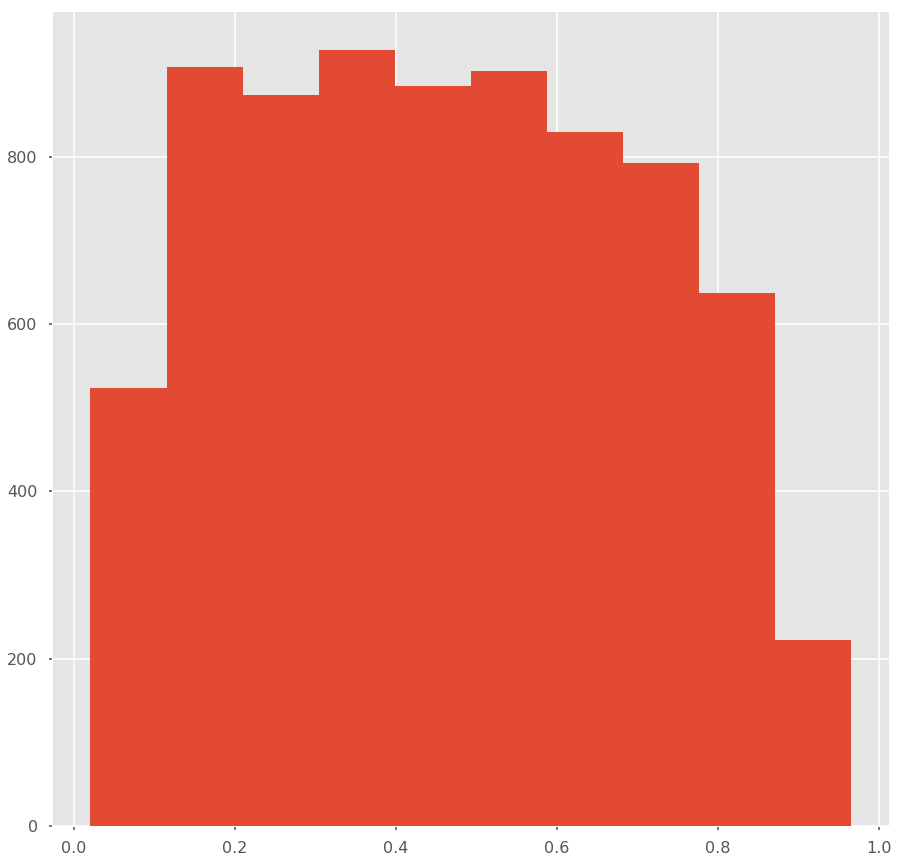

RandomForestClassifier


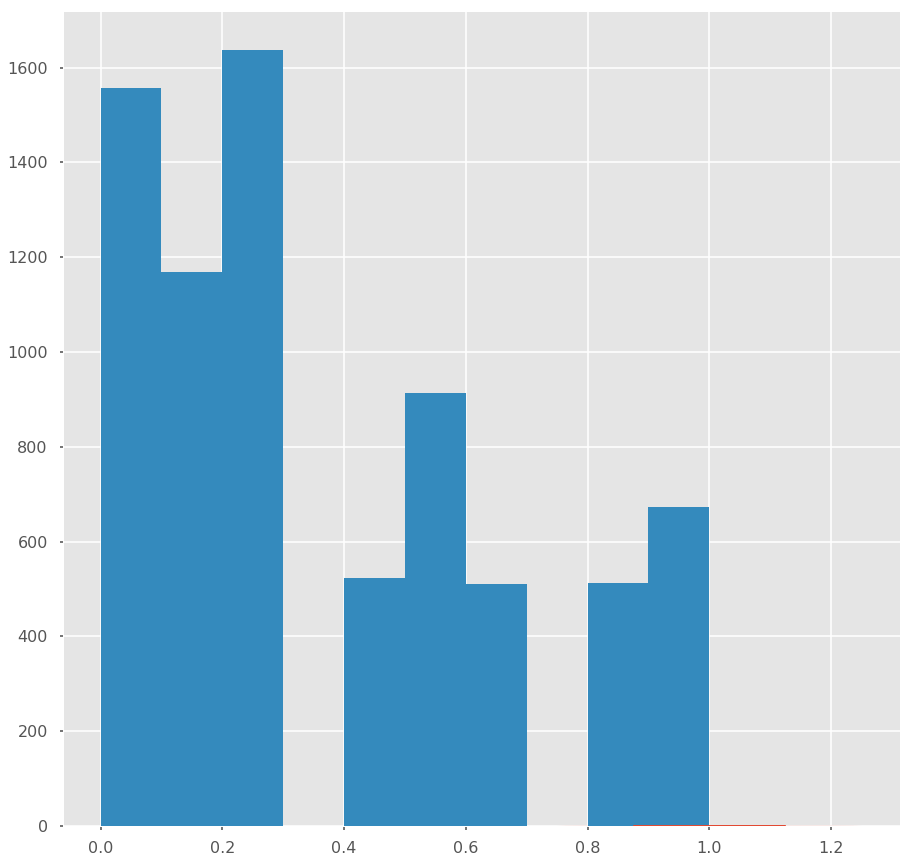

KNeighborsClassifier


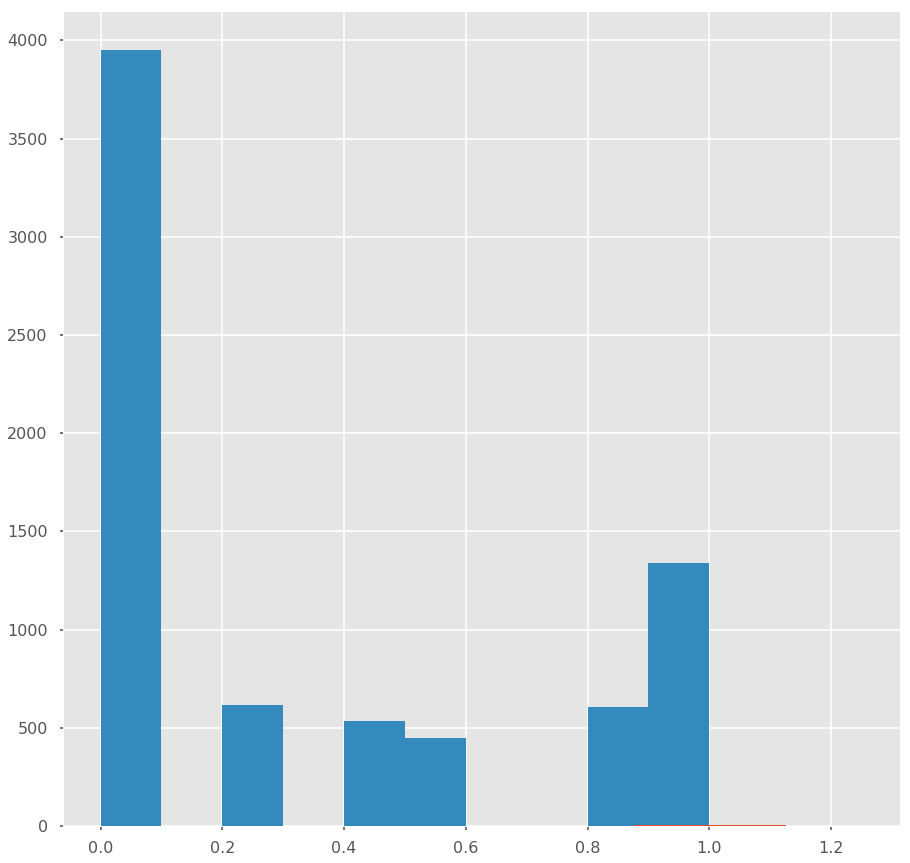

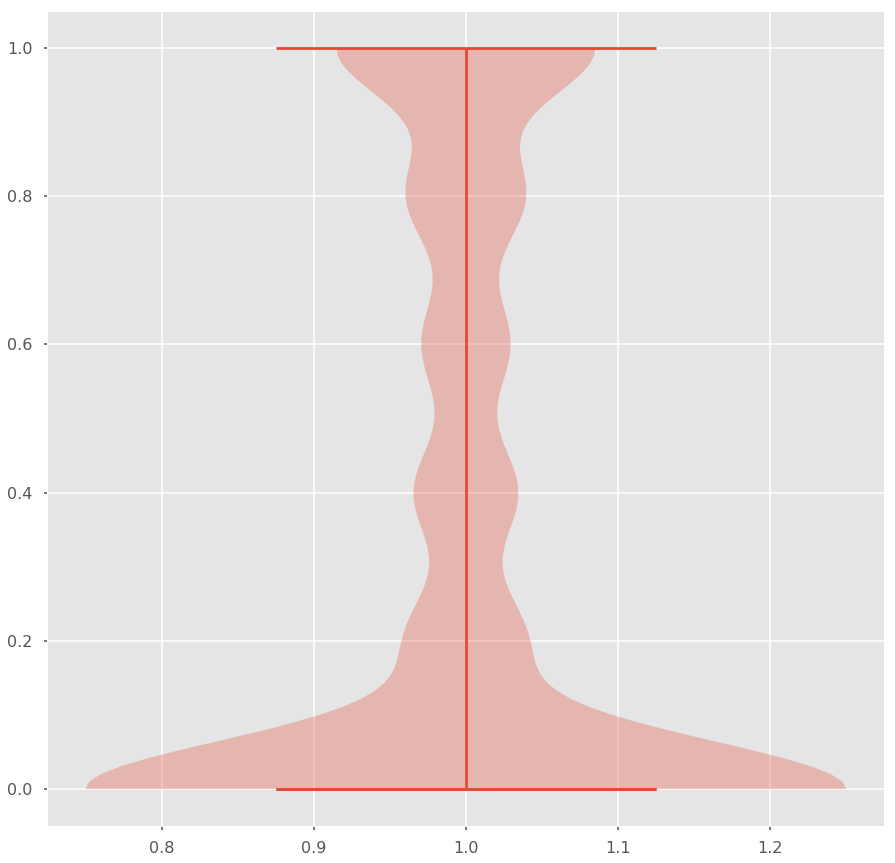

In [161]:
for col_name in voter.df_probas.columns:
    print (col_name)
    voter.df_probas[col_name].hist(bins=10)
    plt.show()
    plt.violinplot(
           voter.df_probas[col_name],
           showmeans=False,
           showmedians=True
        )


LogisticRegression


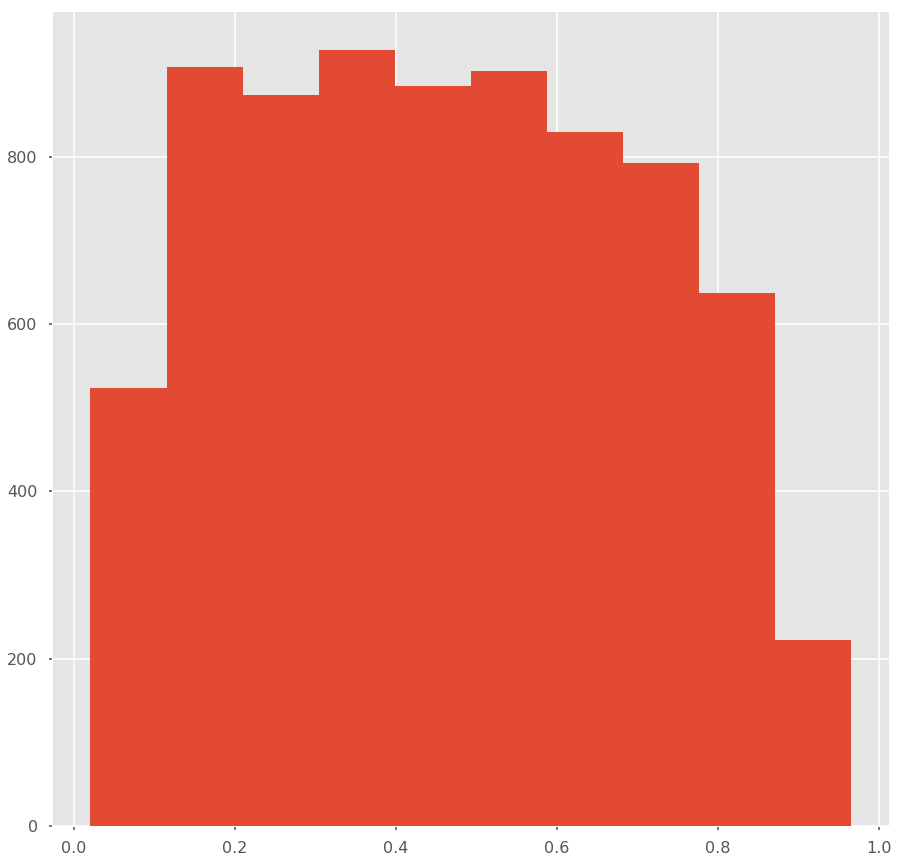

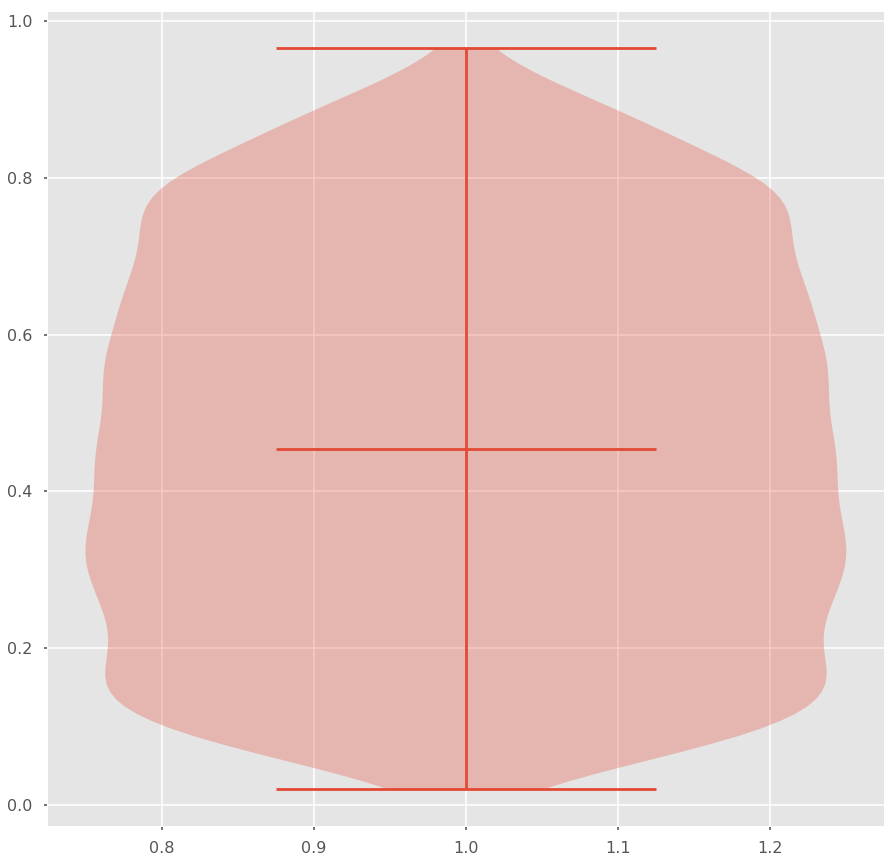

In [159]:
voter.plot_all_distributions()

In [133]:
voter.df_probas['LogisticRegression'].hist()